In [1]:
!pip install einops torch maze-dataset --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import numpy as np
import re
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from maze_dataset.plotting import MazePlot
import random
from torch.nn import functional as F

In [3]:
os.chdir("..")
print(f"Current working directory: {os.getcwd()}")

Current working directory: /


## Loading the Dataset

In [ ]:

from generator.maze.grid_world_generator import generate_multiple_grid_worlds
from generator.maze.solvers.a_star_l1 import main as a_star_l1_paths
from generator.maze.solvers.bfs import main as bfs_paths

parent_directory = "./data"
if not os.path.exists(parent_directory):
    os.makedirs(parent_directory)
# generates the mazes
mazes = generate_multiple_grid_worlds(num_worlds=1000, parent_directory=parent_directory)
# generate path travrsals
a_star_l1_paths(parent_directory)
bfs_paths(parent_directory)

Generating Grid Worlds: 100%|██████████| 1000/1000 [00:00<00:00, 2203.30it/s]

Maze dataset generation complete!


In [20]:
def preprocess_image(image, target_size=32):
    image = np.array(image)
    scale_factor = target_size // image.shape[0]
    # image = np.kron(image, np.ones((scale_factor, scale_factor, 1)))

    # image = image.astype(np.float32) / 127.5 - 1
    image = image.astype(np.float32)
    image = torch.tensor(image).permute(2, 0, 1)
    image = F.interpolate(image.unsqueeze(0), size=(target_size, target_size), mode='nearest').squeeze(0)  # (3, 32, 32)

    return image

def plot_grid_world(grid):
    """
    Plots the given grid world.
    """
    wall = grid[:,:,0] == 0
    source = grid[:,:,1] == 1
    destination = grid[:,:,2] == 1

    img = np.ones((*wall.shape, 3), dtype=np.float32)  # White background
    img[wall] = np.array([0, 0, 0])  # Walls → Black
    img[source] = np.array([1, 0, 0])  # Source → Red
    img[destination] = np.array([0, 1, 0])  # Destination → Green

    return img

def load_dataset_from_npy(directory="./data", target_size=32):
    images = []
    path_lengths = []
    num_nodes_traversed_astar = []
    num_nodes_traversed_bfs = []

    files = sorted([f for f in os.listdir(directory) if f.endswith(".npy")])
    for file in files:
        img = np.load(os.path.join(directory, file))
        if(img.shape != (10,10,3)):
            continue
        # mask = np.all(img == [0, 0, 255], axis=-1)
        # img[mask] = [255, 255, 255]
        # img = img[:-1, :-1]
        # image = preprocess_image(img, target_size)

        image = plot_grid_world(img)
        mask = np.all(image == [0, 0, 255], axis=-1)
        image[mask] = [255, 255, 255]
        image = preprocess_image(image, target_size)

        pattern = r'maze_(\d+)'
        match = re.search(pattern, file)
        num = 0
        if match:
            num = int(match.group(1))
        else:
            continue

        # base_name = os.path.splitext(file)[0]
        # len_filename = base_name + "_len.txt"
        len_filename = f"path_length_{num}" + ".npy"
        len_path = os.path.join(directory, len_filename)
        astar_traversal_filename = f"a_star_{num}" + ".npy"
        astar_traversal_path = os.path.join(directory, "a_star_l1_results" ,astar_traversal_filename)
        bfs_traversal_filename = f"bfs_{num}" + ".npy"
        bfs_traversal_path = os.path.join(directory, "bfs_results" ,bfs_traversal_filename)

        # with open(len_path, "r") as f:
        #     maze_length = int(f.read().strip())
        maze_length = np.load(len_path)
        astar_traversal = np.load(astar_traversal_path)
        bfs_traversal = np.load(bfs_traversal_path)

        images.append(image)
        path_lengths.append(int(maze_length))
        num_nodes_traversed_astar.append(int(astar_traversal))
        num_nodes_traversed_bfs.append(int(bfs_traversal))

    return images, path_lengths, num_nodes_traversed_astar, num_nodes_traversed_bfs

In [21]:
mazes_data_path = "./data/"
images, org_path_lengths, num_nodes_astar, num_nodes_bfs = load_dataset_from_npy(mazes_data_path, target_size=32)

In [22]:
len(images)

1000

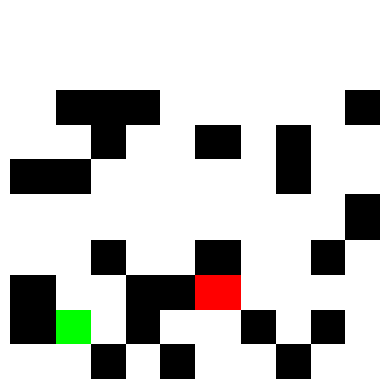

In [23]:
plt.imshow(images[0].permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

# Diffusion

In [24]:
print(f"Current working directory: {os.getcwd()}")

Current working directory: /


### VAE Training

In [25]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from maze_dataset.plotting import MazePlot
import random

In [27]:
# Hyperparameters
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
EPOCHS = 10
LATENT_CHANNELS = 4

In [28]:
class MazeTensorDataset(Dataset):
    def __init__(self, images, path_lengths):
        self.images = images
        self.path_lengths = path_lengths

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.path_lengths[idx]

In [30]:
path_lengths = org_path_lengths

## use the scaled path lengths based on the number of nodes traversed
# path_lengths = [a / b if b!=0 else a for a, b in zip(path_lengths, num_nodes_astar)]
# path_lengths = [a / b if b!=0 else a for a, b in zip(path_lengths, num_nodes_bfs)]

print("Total images:", len(images))
print("Total path_lengths:", len(path_lengths))

total = len(images)
test_size = int(0.2 * total)
all_indices = list(range(total))
random.shuffle(all_indices)

test_indices = all_indices[:test_size]
train_indices = all_indices[test_size:]

train_images = [images[i] for i in train_indices]
train_path_lengths = [path_lengths[i] for i in train_indices]

test_images = [images[i] for i in test_indices]
test_path_lengths = [path_lengths[i] for i in test_indices]

dataset = MazeTensorDataset(train_images, train_path_lengths)
test_dataset = MazeTensorDataset(test_images, test_path_lengths)

print("Train dataset length:", len(dataset))
print("Test dataset length:", len(test_dataset))

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

unique_train_paths = set(train_path_lengths)
print("Unique training path lengths:", unique_train_paths)
print("Number of unique training paths:", len(unique_train_paths))

unique_test_paths = set(test_path_lengths)
print("Unique test path lengths:", unique_test_paths)
print("Number of unique test paths:", len(unique_test_paths))

Total images: 1000
Total path_lengths: 1000
Train dataset length: 800
Test dataset length: 200
Unique training path lengths: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 26, 28}
Number of unique training paths: 22
Unique test path lengths: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
Number of unique test paths: 19


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from diffusers import AutoencoderKL
from torch.utils.data import DataLoader

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Stable Diffusion's pre-trained VAE
vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae").to(device)

# Optimizer (Adam for VAE training)
optimizer = optim.Adam(vae.parameters(), lr=1e-4)

# Loss function (pixel-level reconstruction loss)
criterion = nn.MSELoss()

train_losses = []
# ---- Training Loop ---- #
def train_vae(dataloader, epochs=50):
    vae.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for i, (images, _) in enumerate(dataloader):
            images = images.to(device)  # Input maze images (shape: B x 3 x 256 x 256)

            # Forward pass
            latent_dist = vae.encode(images).latent_dist
            latent_sample = latent_dist.sample()
            reconstructed_images = vae.decode(latent_sample).sample

            # Loss computation
            loss = criterion(reconstructed_images, images)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        train_losses.append(avg_loss)
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.6f}")

train_vae(dataloader, epochs=50)


Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Epoch [1/50], Loss: 0.099281
Epoch [2/50], Loss: 0.076679
Epoch [3/50], Loss: 0.067919
Epoch [4/50], Loss: 0.059364
Epoch [5/50], Loss: 0.050276
Epoch [6/50], Loss: 0.039631
Epoch [7/50], Loss: 0.030288
Epoch [8/50], Loss: 0.022114
Epoch [9/50], Loss: 0.015544
Epoch [10/50], Loss: 0.011595
Epoch [11/50], Loss: 0.009184
Epoch [12/50], Loss: 0.007635
Epoch [13/50], Loss: 0.006793
Epoch [14/50], Loss: 0.006135
Epoch [15/50], Loss: 0.005692
Epoch [16/50], Loss: 0.005403
Epoch [17/50], Loss: 0.005154
Epoch [18/50], Loss: 0.004957
Epoch [19/50], Loss: 0.004822
Epoch [20/50], Loss: 0.004654
Epoch [21/50], Loss: 0.004547
Epoch [22/50], Loss: 0.004432
Epoch [23/50], Loss: 0.004325
Epoch [24/50], Loss: 0.004245
Epoch [25/50], Loss: 0.004177
Epoch [26/50], Loss: 0.004130
Epoch [27/50], Loss: 0.004081
Epoch [28/50], Loss: 0.004033
Epoch [29/50], Loss: 0.003984
Epoch [30/50], Loss: 0.003969
Epoch [31/50], Loss: 0.003902
Epoch [32/50], Loss: 0.003846
Epoch [33/50], Loss: 0.003822
Epoch [34/50], Loss

In [32]:
torch.save({
    'diffusion_state_dict': vae.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses
}, 'diffusion_weights.pth')
print("Diffusion weights saved to diffusion_weights.pth")

Diffusion weights saved to diffusion_weights.pth


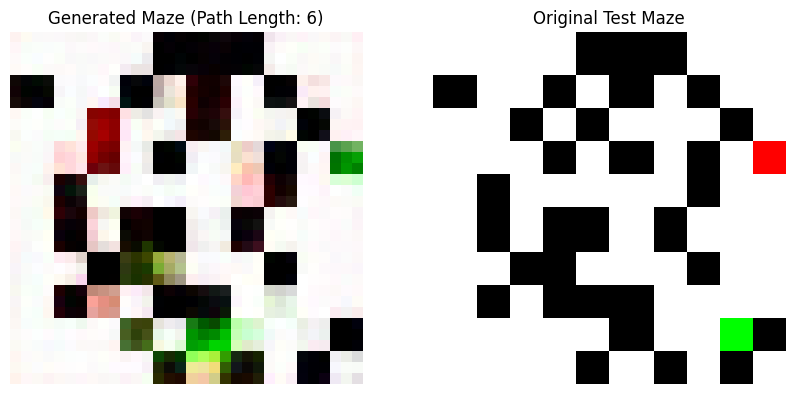

In [33]:
import torch
import random
import matplotlib.pyplot as plt

def generate_maze_from_test(sample_idx=None):
    vae.eval()

    if sample_idx is None:
        sample_idx = random.randint(0, len(test_dataset) - 1)

    test_img, test_path_length = test_dataset[sample_idx]  # Load test maze
    test_img = test_img.unsqueeze(0).to(device)  # Add batch dimension

    # Encode test maze image into latent space
    with torch.no_grad():
        latent_dist = vae.encode(test_img).latent_dist
        latent_sample = latent_dist.sample()  # Sample from the distribution

        # Decode latent back to an image
        generated_image = vae.decode(latent_sample).sample

    return generated_image, test_img, test_path_length

# Run test generation
generated, original, test_path_length = generate_maze_from_test()

# ---- Visualization ---- #
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(generated.squeeze(0).permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.title(f"Generated Maze (Path Length: {test_path_length})")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(original.squeeze(0).permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.title("Original Test Maze")
plt.axis("off")

plt.show()
